In [3]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
import math
import matplotlib.pyplot as plt
from classical import combine_BPAS_classical

import warnings
warnings.filterwarnings('ignore')

# divide data into train_data and test_data
def train_test(all_data, train_ratio):
    train_len = round(len(all_data)*train_ratio)
    np.random.shuffle(all_data)
    train_data = all_data[0:train_len]
    test_data = all_data[train_len:len(all_data)]
    return[train_data,test_data]

# GMM coefficients
def learn_GMM_coefficients(training_set, components_num):
    n = len(training_set)
    m = len(training_set[0])
    weights = [[[[] for item in range(components_num)] for col in range(m)] for row in range(n)]
    means = [[[[] for item in range(components_num)] for col in range(m)] for row in range(n)]
    covariances = [[[[] for item in range(components_num)] for col in range(m)] for row in range(n)]
    for ii in range(n):
        for jj in range(m):
            gmm_coefficients = GaussianMixture(n_components=3).fit(training_set[ii][jj].reshape(-1, 1))
            for item in range(components_num):
                weights[ii][jj][item] = gmm_coefficients.weights_[item]
                means[ii][jj][item] = gmm_coefficients.means_[item][0]
                covariances[ii][jj][item] = gmm_coefficients.covariances_[item][0]
    return weights, means, covariances

# Generate BPAs
def calc_Gaussian(mean,cov,x):
    return (1/np.sqrt(2*np.pi*cov))*np.exp(-np.square(x-mean)/(2*cov))

def calc_mix_Gaussian(weights,means,covs,x):
    components_num = len(weights)
    prob = 0
    for item in range(components_num):
        prob += weights[item]*calc_Gaussian(means[item],covs[item],x)
    return prob[0]

def generate_BPAs(x, weights, means, covariances):
    # x: input testing data (4 atrributes)
    attributes_num = len(x)
    types_num = len(means)
    # BPAs for each attribute
    BPAs = [[] for attribute in range(attributes_num)]
    alphas = [[] for attribute in range(attributes_num)]
    for attribute in range(attributes_num):
        attribute_value = x[attribute]
        # calculate GMM distribution value
        f = [[] for type in range(types_num)]
        for type in range(types_num):
            f[type] = calc_mix_Gaussian(weights[type][attribute],means[type][attribute],covariances[type][attribute],attribute_value)
        f = np.array(f)
        # calculate pi_0 and pi_1
        pi1 = f/max(f)
        pi0 = np.ones(types_num)-pi1
        # calculate the rotation angles
        alpha = np.arctan((pi1+1e-100)/(pi0+1e-100))
        alphas[attribute] = alpha
        # calculate BPA and record
        dimension = 2**types_num
        BPA = [[] for ii in range(dimension)]
        for ii in range(dimension):
            # binary represenation
            bits = "{:0>10b}".format(ii)
            # mass
            m = 1
            for jj in range(types_num):
                bit = bits[-(jj+1)]
                if bit == '1':
                    m *= pi1[jj]
                if bit == '0':
                    m *= pi0[jj]
            BPA[ii] = m
        BPAs[attribute] = BPA
    return BPAs, alphas

# Combining BPAs on quantum circuits and conduct measurement
def combine_qubits(circ, input1, input2, output):
    # x and y (same dimention) are input qubits to be combined by CCR
    # circ is the quantum circuits
    # z is the output qubits for the combined result
    qubits_num = len(input1)
    for qubit in range(qubits_num):
        circ.ccx(input1[qubit],input2[qubit],output[qubit])


def combineBPAs_quantum(alphas, shots):
    attributes_num = len(alphas)
    types_num = len(alphas[0])

    # establish quantum circuits
    qubits_num = (2*attributes_num-1)*types_num
    circ = QuantumCircuit(qubits_num)
    # build quantum BPAs
    for attribute in range(attributes_num):
        for type in range(types_num):
            circ.ry(2*alphas[attribute][type],attribute*types_num+type)
    # combine
    combine_qubits(circ, [0,1,2],[3,4,5],[12,13,14])
    combine_qubits(circ, [6,7,8],[12,13,14],[15,16,17])
    combine_qubits(circ, [9,10,11],[15,16,17],[18,19,20])

    # measurement
    meas = QuantumCircuit(21, 3)
    meas.barrier(range(21))
    # map the quantum measurement to the classical bits
    meas.measure(range(18,21), range(3))
    circ.add_register(meas.cregs[0])
    qc = circ.compose(meas)
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    # print(counts)

    # process the measurement result and output
    dimension = 2**types_num
    combined_BPA = [0 for item in range(dimension)]
    for key in counts.keys():
        value = counts[key]/shots
        index = int(key,2)
        combined_BPA[index] = value

    return combined_BPA

# Decision-making by the combined BPA
def decision_making(BPA):
    dimension = len(BPA)
    types_num = round(math.log2(dimension))
    prob = [0 for ii in range(types_num)]
    for index in range(dimension):
        if BPA[index] != 0:
            mass = BPA[index]
            bin_index = "{:0>10b}".format(index)
            set_num = 0
            for ii in range(types_num):
                if bin_index[-(ii+1)] == '1':
                    set_num += 1
            if set_num != 0:
                mass_divided = mass/set_num
                for ii in range(types_num):
                    if bin_index[-(ii+1)] == '1':
                        prob[ii] += mass_divided
    return prob.index(max(prob))

# Experiments


# Input data processing
df = pd.read_table('iris.data', header=None)
raw_data = np.array(df)
pro_data = [[],[],[]]
for item in raw_data:
    pro_item = str(item[0]).split(',')
    pro_item = [eval(pro_item[0]),eval(pro_item[1]),eval(pro_item[2]),eval(pro_item[3]),pro_item[4]]
    if pro_item[4] == 'Iris-setosa':    
        pro_item[4] = 0
        pro_data[0].append(pro_item)
    if pro_item[4] == 'Iris-versicolor': 
        pro_item[4] = 1
        pro_data[1].append(pro_item)
    if pro_item[4] == 'Iris-virginica':  
        pro_item[4] = 2
        pro_data[2].append(pro_item)
pro_data = np.array(pro_data)


components_num = 3
train_ratio_list = np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

mean_accuracy_quantum_32 = np.empty_like(train_ratio_list)
mean_accuracy_quantum_1024 = np.empty_like(train_ratio_list)
mean_accuracy_classical = np.empty_like(train_ratio_list)

for k in range(len(train_ratio_list)):
    train_ratio = train_ratio_list[k]
    print("Train Ratio: "+ str(train_ratio))

    m = 4 # attribute
    n = 3 # types

    # Monte Carlo experiments 
    N = 100

    accuracy_record_quantum_32 = np.zeros(N)
    accuracy_record_quantum_1024 = np.zeros(N)
    accuracy_record_classical = np.zeros(N)

    for iternum in range(N):
        if iternum % 10 == 0:
            print("Iteration number: "+str(iternum))
        # print(train_ratio, iternum)
        # save training and testing data
        training_set = [[[] for col in range(m)] for row in range(n)]
        testing_set = [[] for row in range(n)]
        # for each type
        for ii in range(n):
            x = train_test(pro_data[ii],train_ratio)
            testing_set[ii] = x[1][:,0:4]
        #     for each attribute
            for jj in range(m):
                training_set[ii][jj] = x[0][:,jj]


        testing_num = 0
        error_num_quantum_32 = 0
        error_num_quantum_1024 = 0
        error_num_classical = 0

        types_num = len(testing_set)

        weights, means, covariances = learn_GMM_coefficients(training_set, components_num)
        
        for ii in range(types_num):
            testing_num += len(testing_set[ii])
            for testing_data in testing_set[ii]:
                BPA, alphas = generate_BPAs(testing_data, weights, means, covariances)
            
                # quantum: 32 shots
                combined_BPA_quantum_32 = combineBPAs_quantum(alphas, 32)
                classification_result_quantum_32 = decision_making(combined_BPA_quantum_32)
                if  classification_result_quantum_32 != ii:
                    error_num_quantum_32 += 1

                # quantum: 1024 shots
                combined_BPA_quantum_1024 = combineBPAs_quantum(alphas, 1024)
                classification_result_quantum_1024 = decision_making(combined_BPA_quantum_1024)
                if  classification_result_quantum_1024 != ii:
                    error_num_quantum_1024 += 1
                
                # classical
                combined_BPA_classical = combine_BPAS_classical(BPA)
                classification_result_classical = decision_making(combined_BPA_classical)
                if  classification_result_classical != ii:
                    error_num_classical += 1
                
        accuracy_record_quantum_32[iternum] = 1 - error_num_quantum_32/testing_num
        accuracy_record_quantum_1024[iternum] = 1 - error_num_quantum_1024/testing_num
        accuracy_record_classical[iternum] = 1 - error_num_classical/testing_num

    mean_accuracy_quantum_32[k] = np.mean(accuracy_record_quantum_32)
    mean_accuracy_quantum_1024[k] = np.mean(accuracy_record_quantum_1024)
    mean_accuracy_classical[k] = np.mean(accuracy_record_classical)

Train Ratio: 0.3
Iteration number: 0


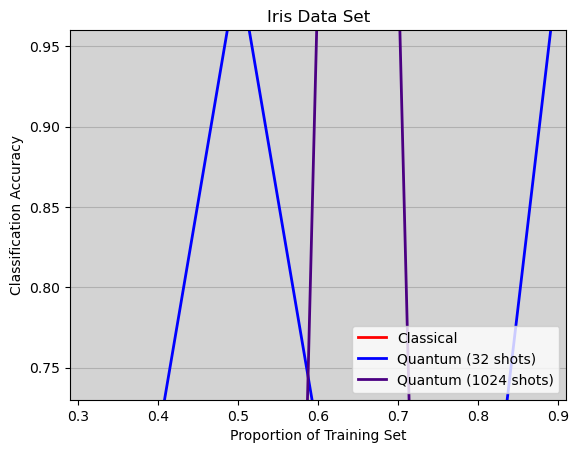

In [2]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
lns1 = ax1.plot(train_ratio_list, mean_accuracy_classical, 'r', linewidth = 2.0, label = 'Classical')
ax1.plot(train_ratio_list, mean_accuracy_classical,'o',color = 'r')
lns2 = ax1.plot(train_ratio_list, mean_accuracy_quantum_32, 'b', linewidth = 2.0, label = 'Quantum (32 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_32,'b^')
lns3 = ax1.plot(train_ratio_list, mean_accuracy_quantum_1024, 'indigo', linewidth = 2.0, label = 'Quantum (1024 shots)')
ax1.plot(train_ratio_list, mean_accuracy_quantum_1024,'>', color = 'indigo')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')
ax1.set_xlim(0.29,0.91)
ax1.set_ylim(0.73,0.96)
ax1.set_ylabel("Classification Accuracy")
ax1.set_xlabel("Proportion of Training Set")
plt.title('Iris Data Set')
ax1.set_facecolor("lightgray")
plt.grid(axis='y')

# plt.savefig('iris.pdf', dpi=400)

In [27]:
np.zeros(3)

array([0., 0., 0.])